In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import itertools
import time

from pathlib import Path
import sys

In [2]:
%load_ext autoreload
%autoreload 2
from policy_utils import Q_learn, get_mle_problem, policy_iteration, get_missing_states, get_medium_substates

In [3]:
# set filepath, read in data
filepath = Path.cwd()
datapath = filepath / 'data'
imagepath = filepath / 'writeup/results'

## Small problem
10 x 10 grid world (100 states) with 4 actions. Actions are 1: left, 2: right, 3: up, 4: down. The discount factor is 0.95.

In [4]:
# read in data
filename = 'small'
data = pd.read_csv(datapath / f'{filename}.csv')

In [5]:
# get states as vectors, index to 0
n, __ = data.shape
s = data.s - 1
spr = data.sp - 1
a = data.a - 1
r = data.r
n_state, n_act = s.nunique(), a.nunique()

# define actions: left, right, up, down
a_dict = {0:-1, 1:1, 2:-10, 3:10}

# define discount
gamma = 0.95

In [6]:
sampled_states, missing_states = get_missing_states(n_state, s)
print('n missing:', len(missing_states))

n missing: 0


In [12]:
# Q-learn
Q = Q_learn(gamma, s, a, r, spr, n_state, n_act, k_max=50)
policyQ_s, __ = np.argmax(Q, axis=1) + 1

100%|███████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


In [19]:
# save results
with open(f'{filename}.policy', 'w') as f:
        for p in policyQ_s:
            f.write(f'{p}\n')

## Medium problem
State measurements are given by integers with 500 possible position values and 100 possible velocity values (50,000 possible state measurements). `1+pos+500*vel` gives the integer corresponding to a state with position pos and velocity vel. There are 7 actions that represent different amounts of acceleration. This problem is undiscounted, and ends when the goal (the flag) is reached. 

In [48]:
# read in data
filename = 'medium'
data = pd.read_csv(datapath / f'{filename}.csv')
n_pos, n_vel, n_act = 500, 100, 7
n_state = n_pos * n_vel
gamma = 1

n, __ = data.shape
s, a, r, spr = data.s.values-1, data.a.values-1, data.r.values, data.sp.values-1

In [21]:
# Q-learn
Q = Q_learn(gamma, s, a, r, spr, n_state, n_act, k_max=25)
policyQ_m = np.argmax(Q, axis=1) + 1

100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.09it/s]


In [22]:
# Fill in with nearest neighbors
# get substates
spos, svel = get_medium_substates(s)
sppos, spvel = get_medium_substates(spr)

sampled_states, missing_states = get_missing_states(n_state, s)
print('n missing:', len(missing_states))

# nearest neighbor policy on remaining policies
k = 1
policyQ_m_nn = policyQ_m.copy()
for si in tqdm(missing_states):
    sposi, sveli = get_medium_substates(si)
    d = np.sqrt((sposi - spos)**2 + (sveli - svel)**2)
    dk_idx = np.argsort(d)[:k]
    dk = d[dk_idx]/d[dk_idx].sum()
    policyQ_m_nn[si] = np.round(policyQ_m[s[dk_idx]] @ dk, 0)

n missing: 28040


100%|████████████████████████████████████| 28040/28040 [03:05<00:00, 151.03it/s]


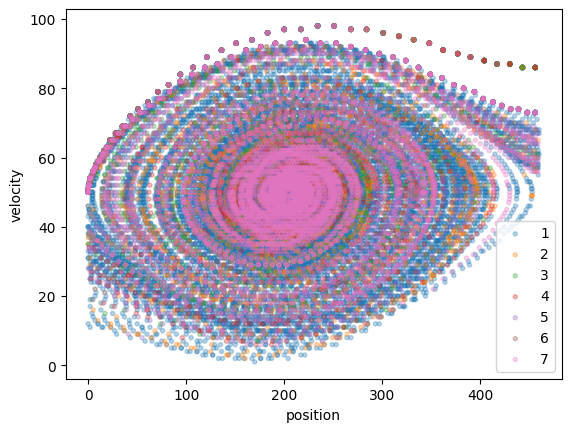

In [51]:
# Visualize
policy_m = policyQ_m_nn
for ps in np.unique(policy_m):
    idx = np.where(policy_m == ps)[0]
    plt.scatter(spos[idx], svel[idx], label=ps, alpha=0.3, marker='.', linestyle='')

plt.xlabel('position')
plt.ylabel('velocity')
plt.legend()
plt.savefig(imagepath / f'{filename}.png')
plt.show()

In [24]:
# save results
with open(f'{filename}.policy', 'w') as f:
        for p in policy_m:
            f.write(f'{p}\n')
            


# Large problem
It’s a secret! MDP with 312020 states and 9 actions, with a discount factor of 0.95. This problem has a lot of hidden structure. Look at the transitions and rewards carefully and you might figure some of it out!

In [58]:
# read in data
filename = 'large'
data = pd.read_csv(datapath / f'{filename}.csv')

n, __ = data.shape
s, a, r, spr = data.s.values-1, data.a.values-1, data.r.values, data.sp.values-1
n_state, n_act = 312020, 9
gamma = 0.95

In [71]:
# get MLE
T_asps, R_sa, __ = get_mle_problem(s, a, r, spr, n_state, n_act)

building dictionary of sparse matrices...
calculating MLE...


  0%|                                                | 0/100000 [00:00<?, ?it/s]/Users/etriesch/dev/battery-charger/venv/battery-charger/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████| 100000/100000 [00:27<00:00, 3691.48it/s]


In [27]:
sampled_states, missing_states = get_missing_states(n_state, s)
print('n missing:', len(missing_states))
print('n sampled:', len(sampled_states))

n missing: 311520
n sampled: 500


In [72]:
# run policy iteration
policyP_l, U = policy_iteration(gamma, sampled_states, R_sa, T_asps, n_state, n_act, k_max=20)

100%|███████████████████████████████████████████| 20/20 [13:20<00:00, 40.01s/it]


In [ ]:
# nearest neighbor policy on remaining policies
sampled_states, missing_states = get_missing_states(n_state, s)
k = 1
policyP_l_nn = policyP_l.copy()
nn_thresh = 1000

for si in tqdm(missing_states):
    if (si >= s.min() - nn_thresh) & (si <= s.max() + nn_thresh):
        d = np.abs(si - s)
        dk_idx = np.argsort(d)[:k]            
        dk = d[dk_idx]/d[dk_idx].sum()
        policyP_l_nn[si] = np.round(policyP_l[s[dk_idx]] @ dk, 0)
    else:
        policyP_l_nn[si] = np.random.randint(n_act)

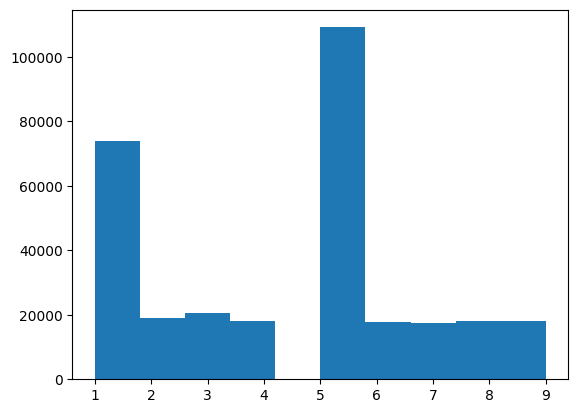

In [36]:
policyP_l_nn += 1
# visualize
plt.hist(policyP_l_nn)
plt.show()

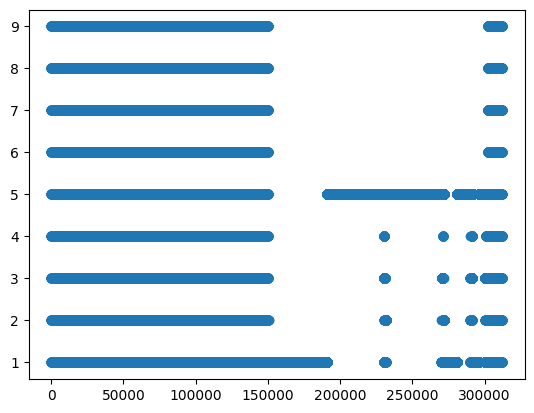

In [43]:
plt.scatter(np.arange(n_state), policyP_l_nn)

In [44]:
# save results
with open(f'{filename}.policy', 'w') as f:
    for p in policyP_l_nn:
        f.write(f'{p}\n')

# Appendix

### Medium: Attempted at model-based approach

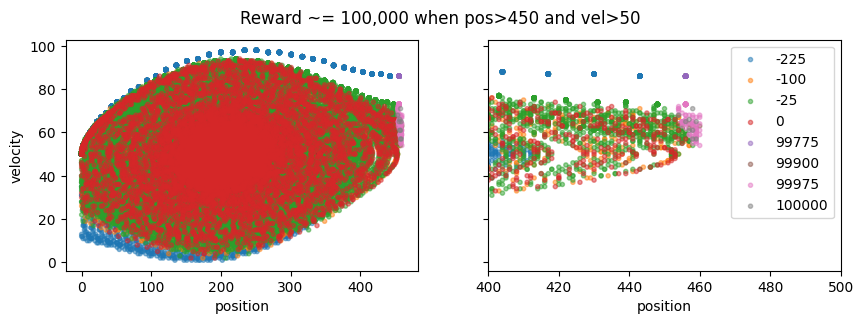

In [39]:
# Visualize the data
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))
for ru in np.unique(r):
    idx = np.where(r == ru)[0]
    ax[0].scatter(spos[idx], svel[idx], label=ru, alpha=0.5, marker='.', linestyle='')
    ax[1].scatter(spos[idx], svel[idx], label=ru, alpha=0.5, marker='.', linestyle='')

fig.suptitle('Reward ~= 100,000 when pos>450 and vel>50')
ax[0].set_xlabel('position')
ax[0].set_ylabel('velocity')
ax[1].set_xlabel('position')
ax[1].set_xlim((400, 500))

plt.legend()
plt.show()

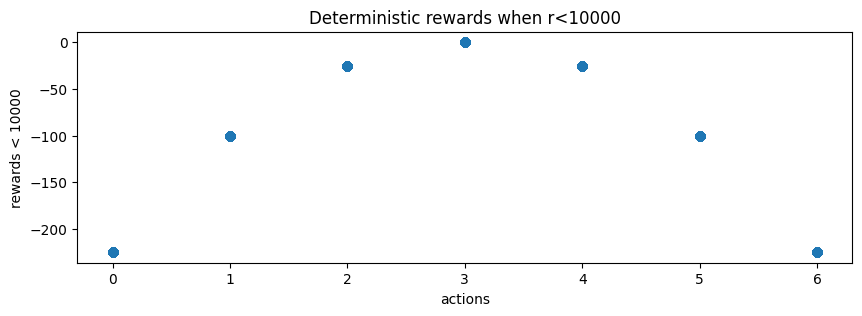

In [40]:
plt.figure(figsize=(10, 3))
plt.scatter(a[r < 10000], r[r<10000])
plt.title('Deterministic rewards when r<10000')
plt.xlabel('actions')
plt.ylabel('rewards < 10000')
plt.show()

In [12]:
# get rewards
thresh_rgt100000 = 50*500+450
R_sa = np.zeros((n_state, n_act))
R_sa[thresh_rgt100000-1:, :] = 100000
R_sa[:thresh_rgt100000, [0,6]] = -225
R_sa[:thresh_rgt100000, [1,5]] = -100
R_sa[:thresh_rgt100000, [2,4]] = -25
R_sa[:thresh_rgt100000, 3] = 0

In [14]:
# get transition probabilities
# predict transition model
# v' <- v + beta1 * a + beta2*cos(pi/200 * x)
# x' <- x + v'
Tv_model = sm.OLS(spvel, np.stack([svel, a, np.cos(np.pi/200 * spos)]).T).fit()
Tp_model = sm.OLS(sppos, np.stack([spos, spvel]).T).fit()

def get_transition_state(s, a):
    spos, svel = get_substates(s)
    
    spvel = Tv_model.predict(np.stack([svel, a, np.cos(np.pi/200 * spos)]).T)
    spvel = np.maximum(np.minimum(spvel, n_vel-1), 0) # bound
    
    sppos = Tp_model.predict(np.stack([spos, spvel]).T)
    sppos = np.maximum(np.minimum(spos + spvel, n_pos-1), 0) # bound
    return get_state(sppos, spvel.round(0))

T_sa = np.zeros((n_state, n_act), dtype=int)
for ai in range(n_act):
    T_sa[:, ai] = get_transition_state(np.arange(n_state), np.repeat(ai, n_state))

In [ ]:
# Q learning alternative, with random gapfilling
Q = np.zeros((n_state, n_act))
alpha = 1/n

m = 500
possible_states = np.arange(n_state)
sampled_states = np.where(np.in1d(possible_states, s))[0]

for i in tqdm(range(m)):
    
    # iterate through samples
    for j in range(n):
        Q[s[j], a[j]] += (1/m) * gamma * (r[j] + np.max(Q[spr[j]]) - Q[s[j], a[j]])

    # For states without samples, iterate using modeled reward and transition
    for j in range(n_state):
        if j not in sampled_states:
            for k in range(n_act):
                Q[j, k] += (1/m) * gamma * (R_sa[j, k] + np.max(Q[T_sa[j, :]]) - Q[j, k])

    
policyQ_mm = np.argmax(Q, axis=1) + 1

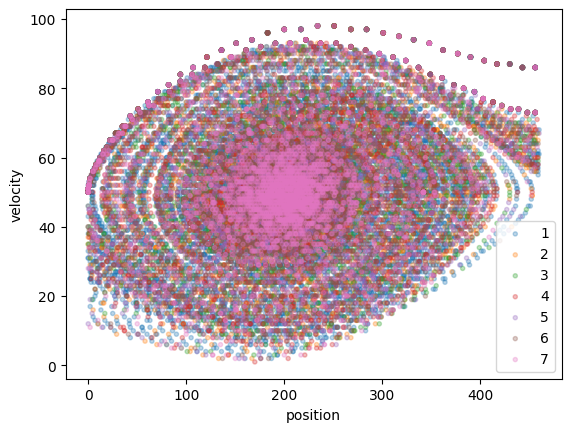

In [37]:
# Visualize
for ps in np.unique(policyQ_mm):
    idx = np.where(policyQ_mm == ps)[0]
    plt.scatter(spos[idx], svel[idx], label=ps, alpha=0.3, marker='.', linestyle='')

plt.xlabel('position')
plt.ylabel('velocity')
plt.legend()
plt.show()